In [1]:
import matplotlib.image as mpimg
import scipy.misc as spmisc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog


In [2]:
%matplotlib inline

# Load Data

In [3]:
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

In [11]:
def read_image(file):
    return spmisc.imread(file)

In [12]:
def read_image_data(path):
    files = glob.glob(path)
    images = np.array([read_image(f) for f in files])
    return files, images

In [5]:
# Read in vehicles data
car_files, car_images = read_image_data('data/vehicles/*/*.*')

print('number of car files: {}'.format(len(car_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in car_files])))
print('car images array shape: {}'.format(car_images.shape))

number of car files: 8792
unique file extensions: ['.png']
car images array shape: (8792, 64, 64, 3)


In [6]:
# Read in NON-vehicles data
noncar_files, noncar_images = read_image_data('data/non-vehicles/*/*.*')

print('number of non-car files: {}'.format(len(noncar_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in noncar_files])))
print('non-car images array shape: {}'.format(noncar_images.shape))

number of non-car files: 9666
unique file extensions: ['.png']
non-car images array shape: (9666, 64, 64, 3)


In [7]:
# combine data. the classes are quite balanced
allimages = np.vstack([car_images, noncar_images])
alllabels = np.hstack([np.ones(len(car_images)), np.zeros(len(noncar_images))]).astype(np.uint8)

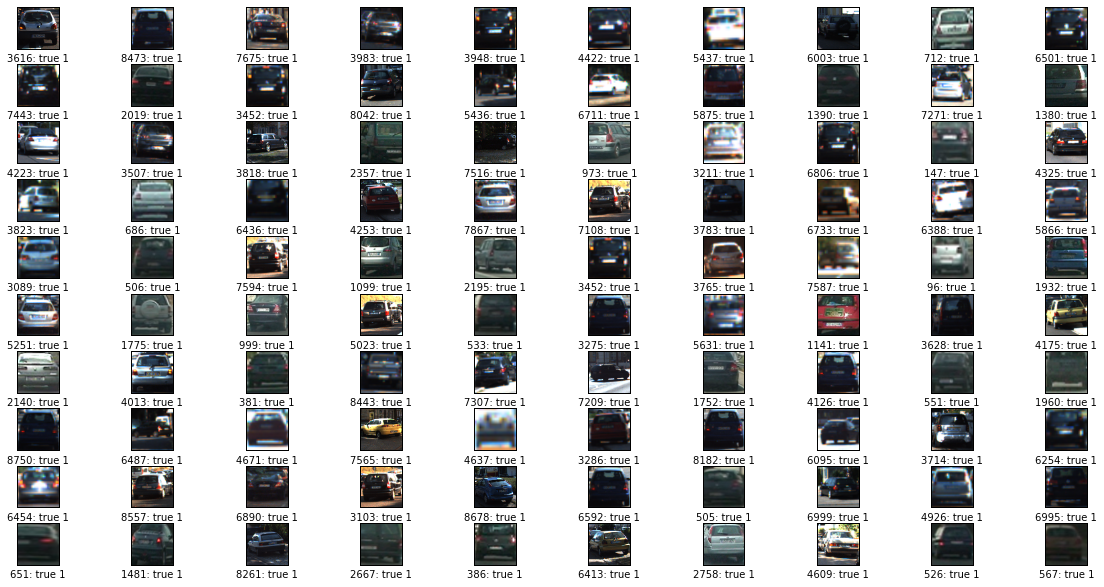

In [8]:
# cars
show_images(allimages, alllabels, 10, 10, cls=1)

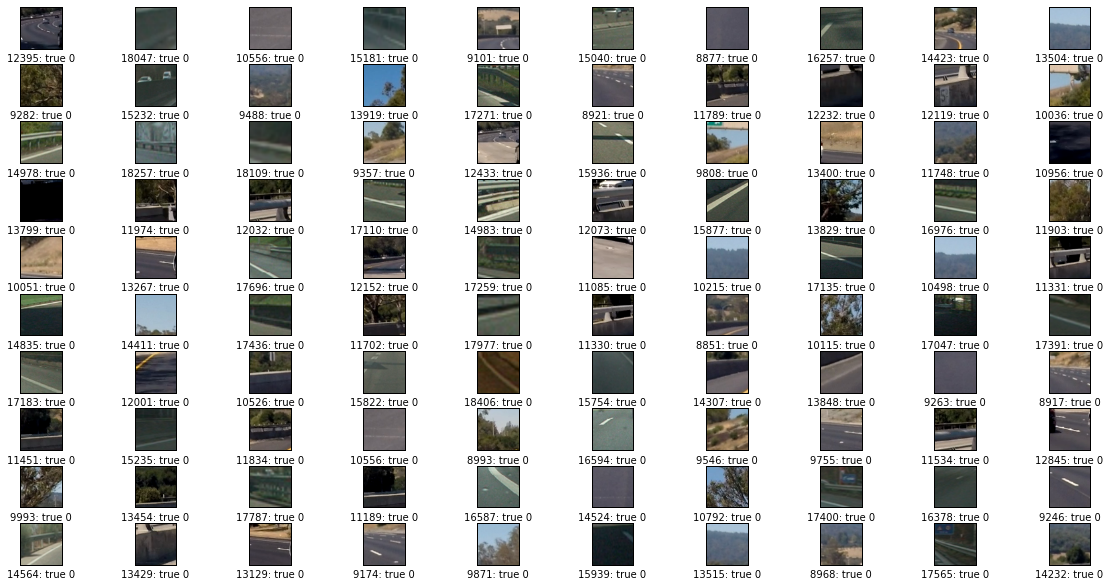

In [9]:
# NON-cars
show_images(allimages, alllabels, 10, 10, cls=0)

# test image

In [13]:
image = read_image('test_images/test3.jpg')

# define features

In [31]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if (color_space=='RGB'):
        tmpimg = img
    else:
        cv2color = eval('cv2.COLOR_RGB2'+color_space)
        tmpimg = cv2.cvtColor(img, cv2color)
    small_img = cv2.resize(tmpimg, size)
    features = small_img.ravel()
    return features

In [32]:
small_image_size = (32,32)

In [36]:
feature_vec = bin_spatial(image, color_space='HLS', size=small_image_size)
feature_vec.shape

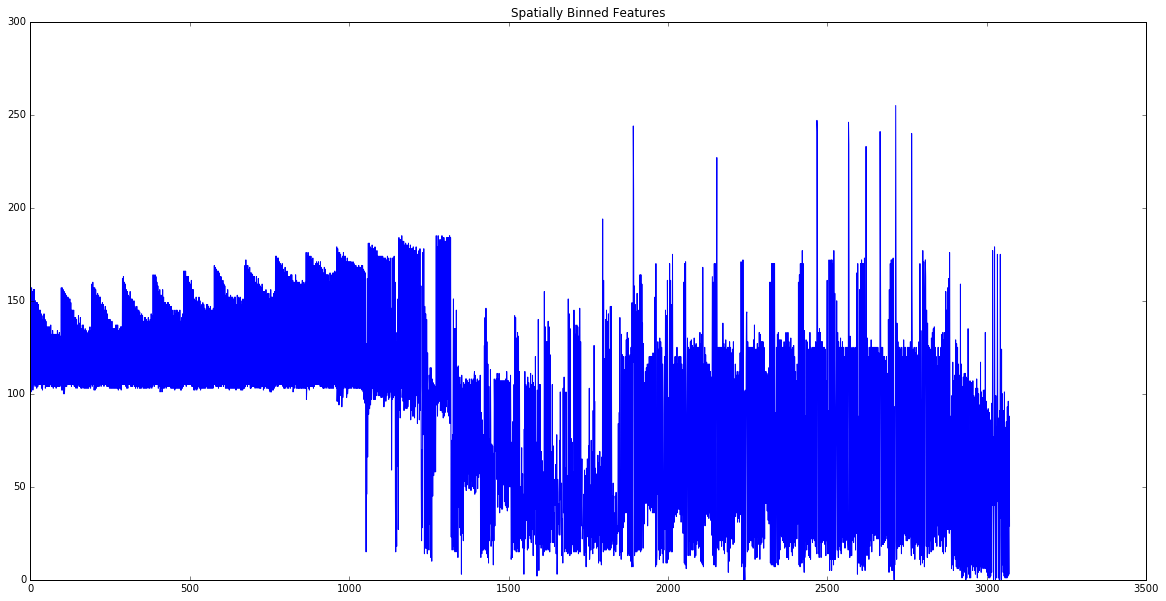

In [38]:
plt.plot(feature_vec)
plt.title('Spatially Binned Features');

In [ ]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img,
                                          orientations=orient,
                                          pixels_per_cell=(pix_per_cell,pix_per_cell),
                                          cells_per_block=(cell_per_block,cell_per_block),
                                          visualise=True,
                                          transform_sqrt=True,
                                          feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img,
                                          orientations=orient,
                                          pixels_per_cell=(pix_per_cell,pix_per_cell),
                                          cells_per_block=(cell_per_block,cell_per_block),
                                          visualise=False,
                                          transform_sqrt=True, # gamma correction
                                          feature_vector=feature_vec)
        return features


In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient,
                        pix_per_cell, cell_per_block,
                        vis=True, feature_vec=False)


In [ ]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [39]:
#Patrick Kern [1:57 AM]
#Anyone played around with opencvs hog extractor? It is way faster. Like 20 times. Unfortunately I get significant worse results on my LinearSMV compared to skimages hog features. auc 0.995 vs 0.966. (edited)
# Good to know that it's just skimages hog thats slow and not hog in general
#Patrick Kern [3:44 PM]
#I also did a second gridsearch with the opencv hog extractor which has more parameters. I ended up with 30,000 fits which took 2750 min but still had worse accuracy than the skimage hog extractor

#@rushabh: couple of things you can implement to speed up your pipeline. 
#1) use a roi and only hog that portion of the image 
#2) make sure you extract hog as a feature matrix 
#3) make sure your sliding window overlap is not to much 
#4) keep feature vector at around 3000-5000 features. Less is better 
#5) only check the images at two scales 
#6) create an average heat map
